In [43]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
#Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1




In [44]:

# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

#!wget --no-check-certificate \
#    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
#    -O /tmp/training_cleaned.csv

In [45]:
corpus = []

num_sentences = 0

with open("/tmp/training_cleaned/training_cleaned.csv", encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. 
        # Note that the label is a '0' or a '4' in the text. When it's the former, make
        # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        text=row[5]
        
        if row[0]=="0":
            label=0
        else:
            label=1
        
        
        list_item=[text, label]
        
        # YOUR CODE HERE
        num_sentences = num_sentences + 1
        corpus.append(list_item)




In [46]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [47]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = np.array(pad_sequences(sequences, maxlen=max_length)) 

split = int(test_portion * training_size)

test_sequences = np.array(padded[:split])
test_labels = np.array(labels[:split])

training_sequences =np.array(padded[split:])
training_labels = np.array(labels[split:training_size])

In [48]:
training_sequences.shape

(144000, 16)

In [49]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138925
1


In [50]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier

# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
#     -O /tmp/glove.6B.100d.txt
    
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [51]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138926


In [52]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(65, 5),
    tf.keras.layers.MaxPool1D(4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

num_epochs = 50

history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 16, 100)           13892600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 12, 65)            32565     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 65)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                33280     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 13,958,510
Trainable params: 65,910
Non-trainable params: 13,892,600
_____________________________________

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

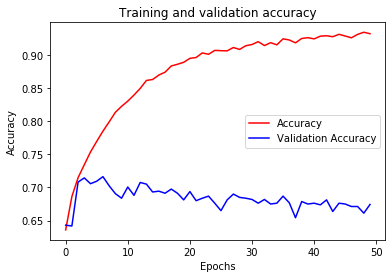

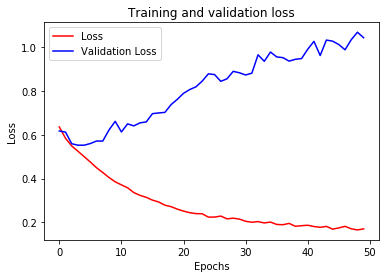

<Figure size 432x288 with 0 Axes>

In [53]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!